This fil will test out the plotting of time series and the derivation of indicators on financial data.
First, data needs to be fetched from Oanda - the broker of choice.

In [2]:
from interface import Interpretor

accounts =Interpretor.getAccounts()
accounts

{'accounts': [{'id': '101-002-30846328-001', 'tags': []}]}

In [3]:
Interpretor.selectAccount(0)
Interpretor.getPrices('CAD_JPY', 'M15', '2022-01-01T00:00:00Z', 'CAD_JPY_M15_2022-01-01')

M15
Number of candles: 112387
Number of candles is too large, splitting into multiple requests
Number of requests: 22
Start DateTime: 2022-01-01T00:00:00Z
End DateTime: 2022-02-22T02:00:00Z
Number of candles returned: 3472
Start DateTime: 2022-02-22T02:00:00Z
End DateTime: 2022-04-15T04:00:00Z
Number of candles returned: 3660
Start DateTime: 2022-04-15T04:00:00Z
End DateTime: 2022-06-06T06:00:00Z
Number of candles returned: 3453
Start DateTime: 2022-06-06T06:00:00Z
End DateTime: 2022-07-28T08:00:00Z
Number of candles returned: 3656
Start DateTime: 2022-07-28T08:00:00Z
End DateTime: 2022-09-18T10:00:00Z
Number of candles returned: 3500
Start DateTime: 2022-09-18T10:00:00Z
End DateTime: 2022-11-09T12:00:00Z
Number of candles returned: 3608
Start DateTime: 2022-11-09T12:00:00Z
End DateTime: 2022-12-31T14:00:00Z
Number of candles returned: 3496
Start DateTime: 2022-12-31T14:00:00Z
End DateTime: 2023-02-21T16:00:00Z
Number of candles returned: 3524
Start DateTime: 2023-02-21T16:00:00Z
End D

In [ ]:
import pandas as pd
import json

data_file = None
with open('CAD_JPY_M15_2022-01-01.json', 'r') as f:
    data = json.loads(f.read())

candles = data["candles"]

df = pd.DataFrame(candles)
df.head()

,complete,volume,time,bid,ask
0,True,13,2022-01-02T22:00:00.000000000Z,"{'o': '90.981', 'h': '90.983', 'l': '90.970', ...","{'o': '91.181', 'h': '91.183', 'l': '91.170', ..."
1,True,49,2022-01-02T22:15:00.000000000Z,"{'o': '91.000', 'h': '91.010', 'l': '90.963', ...","{'o': '91.200', 'h': '91.210', 'l': '91.163', ..."
2,True,18,2022-01-02T22:30:00.000000000Z,"{'o': '90.992', 'h': '91.002', 'l': '90.977', ...","{'o': '91.192', 'h': '91.202', 'l': '91.177', ..."
3,True,27,2022-01-02T22:45:00.000000000Z,"{'o': '90.993', 'h': '91.022', 'l': '90.957', ...","{'o': '91.193', 'h': '91.197', 'l': '91.157', ..."
4,True,781,2022-01-02T23:00:00.000000000Z,"{'o': '90.967', 'h': '91.125', 'l': '90.966', ...","{'o': '91.167', 'h': '91.175', 'l': '91.083', ..."


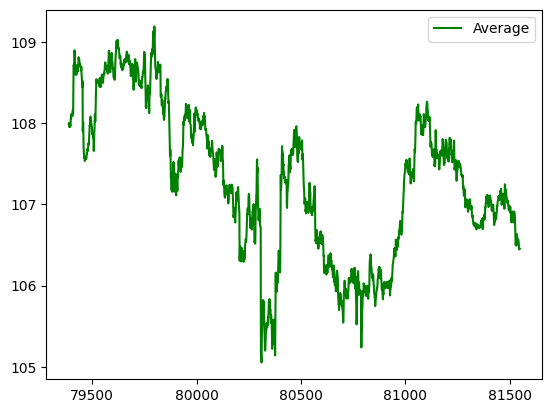

In [115]:
#plot the data over the past 3 days. This should be about 3*24*60/15 = 720*3 = 2160 candles

from matplotlib.category import StrCategoryConverter
import matplotlib.pyplot as plt
import matplotlib

sub_df = df[-2160:]#grab the last 720 candles

averages = sub_df["bid"].apply(lambda x: float(x.get("l",None)) + (float(x.get("h", None)) - float(x.get("l", None)))/2)

highs =sub_df["bid"].apply(lambda x: float(x.get("h", None)))
lows = sub_df["bid"].apply(lambda x: float(x.get("l", None)))



plt.figure()
plt.plot(averages, color='green')

# plt.plot(lows, color='blue')
# plt.plot(highs, color='red')


plt.legend(['Average', 'High', 'Low'])
plt.show()



Now to make some indicators on the dataset

First, I will attempt plotting RSI (Relative Strength Index). This ranges from 0 - 100 and is based on losses and gains compared to a certain anchor (entry) point a certain time ago.
RSI can be recursive, but the first RSI calculation is:

100 - (100/(1+ (avg_gain/ avg_loss)))

Every subsequent RSI calculation is:

100 - (100/(1 + ((cur_gain + prev_avg_gain*(time_step-1))/ (cur_loss + prev_avg_loss * (time_step-1)))))

The time period (time_step) determines how sensitive the RSI is to changes in the market. If I want to capture long-term trends with RSI, the time step can go to about 20-30, otherwise 14 is a good balance (test this out later - there's optimization potential here)

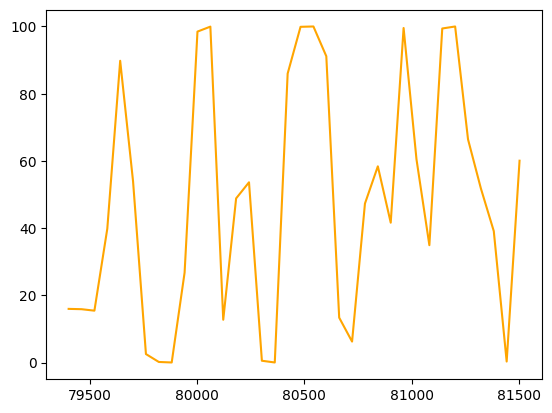

In [157]:
def populateAverages( df, cur_index, time_step):
    gains = []
    losses = []
    for i in range(time_step):
        cur_percentage = df.iloc[cur_index]
        if cur_percentage >= 0:
            gains.append(cur_percentage)
        else:
            losses.append(abs(cur_percentage))
        cur_index += 1

    avg_loss = sum(losses)/time_step
    avg_gain = sum(gains)/time_step
    
    return avg_loss, avg_gain

time_step = 14
index_step = 60 #adjust this to change the shift in the time window - higher values give RSI for longer periods (depends on the original granularity of the dataset)

#calculate RSI
#I will avoid recursion and will just traverse the df as it it was a linked list - there may be enough values in the df to overflow the stack with recursion otherwise

rsi = []
indices = []

percentages = sub_df["bid"].apply(lambda x: (float(x.get("o", None)) - float(x.get("c", None)))/float(x.get("o", None)))

cur_index = time_step
prev_avg_loss, prev_avg_gain = populateAverages(percentages, cur_index, time_step)
prev_avg = 0

while(cur_index < len(averages)):
    #print(prev_avg_loss, prev_avg_gain)
    cur_percentage = percentages.iloc[cur_index]
    cur_gain = cur_percentage if cur_percentage > 0 else 0
    cur_loss = abs(cur_percentage) if cur_percentage < 0 else 0

    rsi.append((100 - (100/(1 + (cur_gain + prev_avg_gain*(cur_index))/ (cur_loss + prev_avg_loss * (cur_index))))))

    prev_avg_loss = (cur_loss + prev_avg_loss*(time_step))/(cur_index)
    prev_avg_gain = (cur_gain + prev_avg_gain*(time_step))/(cur_index)
    indices.append(sub_df.index[cur_index])
    cur_index += index_step

rsi_df = pd.DataFrame(rsi)
rsi_df.index = indices


plt.figure()
plt.plot(rsi_df, color = 'orange')
plt.show()







Now I will try to calculate ADX (trend strength indicator)

Unlike RSI, this showcases the strength of the current trend of a symbol - how likely it is to continue doing what it's already doing. This does not tell whether the symbol is about to go up or down.